In [1]:
using JuMP, CPLEX
using Plots
n=100

coord=[([30*rand();15*(1+rand())]) for _ in 1:n]
coord=[30*rand(2) for _ in 1:n]

using JLD
file = jldopen("coord2.jld", "r", mmaparrays=true)
coord = read(file, "coord") 



function euclidean_distance(p1, p2)
    return sqrt((p1[1] - p2[1])^2 + (p1[2] - p2[2])^2)
end

c = zeros(n, n)

for i in 1:n
    for j in 1:n
        c[i, j] = euclidean_distance(coord[i], coord[j])
    end
end

In [2]:
k=25
b=90
m=Model(CPLEX.Optimizer)
@variable(m, x[1:n, 1:n]>=0,Bin)
@variable(m,u[1:n]>=0)
set_optimizer_attribute(m, "CPX_PARAM_TILIM", 1000)  # Set time limit to 200 seconds
for j in 2:n
    @constraint(m, sum(x[i, j] for i = 1:n)-x[j,j] == 1)
    @constraint(m, sum(x[j, i] for i = 1:n)-x[j,j] == 1)
end

@constraint(m, sum(x[i, 1] for i = 1:n)-x[1,1] <= k)
@constraint(m, sum(x[1, i] for i = 1:n)-x[1,1] <= k)

@constraint(m, sum(x[1, i] for i = 1:n)-sum(x[i, 1] for i = 1:n)==0)

@constraint(m,u[1]==0)
for i in 1:n
    for j in 2:n
        if i!=j
           @constraint(m, u[j]-u[i]-c[i,j]*x[i,j]>=-90*(1-x[i,j])) 
           @constraint(m, u[j]-u[i]-c[i,j]*x[i,j]<=90*(1-x[i,j])) 
        end
    end
end


for i in 1:n
        @constraint(m, u[i]+c[i,1]<=b)
end

@objective(m,Min,sum(c[i,j]*x[i,j] for i=1:n, j=1:n))

optimize!(m)

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_TimeLimit                               1000
Tried aggregator 1 time.
MIP Presolve eliminated 101 rows and 101 columns.
MIP Presolve modified 39204 coefficients.
Reduced MIP has 19803 rows, 9999 columns, and 78606 nonzeros.
Reduced MIP has 9900 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.06 sec. (35.38 ticks)
Probing time = 0.12 sec. (8.75 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 19803 rows, 9999 columns, and 78606 nonzeros.
Reduced MIP has 9900 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.16 sec. (40.24 ticks)
Probing time = 0.11 sec. (8.73 ticks)
Clique table members: 1519.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 16 threads.
Root relaxation solution time = 0.11 sec. (42.97 ticks)

        Nodes                                         Cuts/
   Node  Left     Object

379123790811127917021164954751495509318225613041964634084123399294295283312856513471531520574473107789825652758145982766626383372174347354166986367832100809948871885597962459428598466013746768621

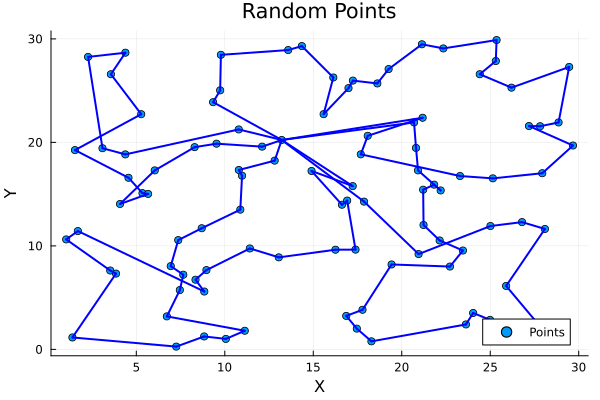

In [3]:
function stsp_path(next)
    j=1
    path=[]
    push!(path,1)
    while next!=1
       j=j+1
        push!(path,next)
        for i in 1:n
            if round(value(x[next,i]))==1
                next=i
                break
            end
        end
    end
    push!(path,1)
    path=convert.(Int,path)
    return path
end
    
path=[]
for i in 1:n
        if round(value(x[1,i]))==1
           push!(path,stsp_path(i))
        end
end

    
x_coords = [point[1] for point in coord]
y_coords = [point[2] for point in coord]

# Plot the points
scatter(x_coords, y_coords, label="Points", xlabel="X", ylabel="Y", title="Random Points")

for (i,temp) in enumerate(path)
    for (j,_) in enumerate(temp[1:end-1])
        plot!([coord[path[i][j]][1], coord[path[i][j+1]][1]], [coord[path[i][j]][2], coord[path[i][j+1]][2]], color=:blue, lw=2, label="")
        print(path[i][j+1])
    end
end
plot!()


In [4]:
k=sum(value(x[1, i]) for i = 1:n)

4.0

In [5]:
Tr=[]
for (i,temp) in enumerate(path)
    cost=0
    for (j,_) in enumerate(temp[1:end-1])
        cost=cost+c[temp[j],temp[j+1]]
    end
    push!(Tr,cost)
end
Tr

4-element Vector{Any}:
 86.2602810985082
 83.17700820346138
 79.4895327219164
 53.5020892527954

In [6]:
function new_T(node_values,lb,ub)

function my_lcm(a, b)
    return (a * b) ÷ gcd(a, b)
end

function dijkstra_lcm(graph, src, target)
    n = length(keys(graph))+1
    lcm_values = fill(Inf, n+1) 
    lcm_values[src] = 1
    pq = [(1, src)]  # Priority queue of (lcm, vertex) tuples
    visited = fill(false, n+1)
    predecessors = fill(-1, n+1)  
    
    while !isempty(pq)
        
        pq=sort(pq,rev=true)
        (current_lcm, u) = pop!(pq) 
        
        if visited[u]
            continue  
        end

        if u == target
            path = [u]
            while predecessors[u] != -1
                push!(path, predecessors[u])
                u = predecessors[u]
            end
            return current_lcm, reverse(path) 
        end

        visited[u] = true 

        for (v, weight) in graph[u]
        
            new_lcm = my_lcm(current_lcm, weight)
            if new_lcm < lcm_values[v]
                lcm_values[v] = new_lcm
                push!(pq, (new_lcm, v))
                predecessors[v] = u
            end
        end
    end

    return -1  # Target not reachable
end


function create_graph(node_values)
    n = length(node_values)
    graph = Dict()

    # Start vertex
    graph[1] = sort(Dict(1 + i => v for (i, v) in enumerate(vertices_in_range(node_values[1]))))

    # Core nodes
    for i in 1:(n-1) 
        vertices = vertices_in_range(node_values[i])
        next_vertices = vertices_in_range(node_values[i + 1])

        k0=maximum(keys(graph))
        k1=minimum(keys(graph[k0]))
        k2=maximum(keys(graph[k0]))
    
        for (i, v) in enumerate(vertices)
            graph[k1+i-1] = sort(Dict(k2 + j => u for (j, u) in enumerate(next_vertices)))
        end
    end

    # End vertex
        k0=maximum(keys(graph))
        k1=minimum(keys(graph[k0]))
        k2=maximum(keys(graph[k0]))
        
    vertices = vertices_in_range(node_values[n])  
    for (i, v) in enumerate(vertices)
        graph[k1+i-1] = Dict(k2 + 1 => 1)  
    end

    return graph
end

function vertices_in_range(pi)
    lower = ceil(pi - lb*pi)
    upper = floor(pi + ub*pi)
    vertices = [] 
    step_size = 1  

    value = lower
    while value <= upper
        push!(vertices,Int(value)) 
        value += step_size
    end
    vertices=sort(vertices)
    return vertices
end

    
graph = create_graph(node_values)
k0=maximum(keys(graph))
k1=maximum(keys(graph[k0]))
start = 1
target = k1
graph1=sort(graph)
shortest_path_lcm = dijkstra_lcm(graph, start, target)

T_new=[]
for (i,j) in enumerate(shortest_path_lcm[2][1:end-2])
    push!(T_new,graph[j][shortest_path_lcm[2][i+1]])
end

    return T_new
    
end


new_T (generic function with 1 method)

In [7]:
using LinearAlgebra
using JuMP, CPLEX
using Plots
using LinearAlgebra

Set_drones=[[25; 25],[25; 25],[50; 50],[110; 95],[100; 90]]
Set_numbers=[5,5,5,5,5]
Set_C = Set_drones[1, :]
Set_F = Set_drones[2, :]

temp = [repeat(Set_drones[i], 1, Set_numbers[i]) for i in 1:5]

D = hcat(temp...)


#=
D1 = repeat(Set_drones[1], 1, Set_numbers[1])
D2 = repeat(Set_drones[2], 1, 5)
D3 = repeat(Set_drones[3], 1, 5)
D4 = repeat(Set_drones[4], 1, 5)
D5 = repeat(Set_drones[5], 1,5)

D = hcat(D1, D2, D3, D4, D5)
=#
K=size(Tr)


n = size(D, 2)
g = gcd([D[1, :]..., D[2, :]...])
#D = D / g
C = D[1, :]
F = D[2, :]
T = sum(D, dims=1)
t = lcm(map(Int, T))
nums = Int(sum(T))
T_max = maximum(T)

T_new=new_T(T,0,0.1)
t1 = lcm(map(Int, T_new))

N=t1./T_new  


temp=T-T_new'
for i in 1:n
    D[2,i]=D[2,i]-temp[i]
end


C = D[1, :]
F = D[2, :]
g = gcd([D[1, :]..., D[2, :]...])
#D = D / g
T = sum(D, dims=1)
t = lcm(map(Int, T))
nums = Int(sum(T))
T_max = maximum(T)

N=t./T

N

1×25 Matrix{Float64}:
 4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [8]:
A = zeros(n, nums)

p_matrix = []
A_matrix = []

k = 1

for i in 1:n
    A[i, k:k+Int(T[i])-1] .= 1    # equality
    k += Int(T[i])
    
    p_i = zeros(Int, Int(T[i]))
    p_i[1:Int(C[i])] .= 1
    push!(p_matrix, p_i)
end

A_bar = zeros(t, nums) # inequality

for i in 1:t
    k = 1
    for j in 1:n
        A_bar[i, k:k+Int(T[j])-1] .= circshift(p_matrix[j], i-1)
        k += Int(T[j])
    end
    
end

eligible_drones=[]

for i in 1:size(Tr)[1]
    drones=[]
    for j in 1:size(F)[1]
        if F[j]>=Tr[i]
            push!(drones,j)
        end
    end
    push!(eligible_drones,drones)
end


eligible_sites=[]

for i in 1:size(F)[1]
    sites=[]
    for j in 1:size(Tr)[1]
        if F[i]>=Tr[j]
            push!(sites,j)
        end
    end
    push!(eligible_sites,sites)
end



k=size(Tr)[1]

4

In [9]:
model=Model(CPLEX.Optimizer)

@variable(model,x[1:nums],Bin)
@variable(model,w[1:n],Bin)
@variable(model,v[1:n,1:k],Bin)
@variable(model,m)


@constraint(model,A*x==w)
@constraint(model,A_bar*x.<=m)



for (i,j) in enumerate(eligible_sites)
    @constraint(model,sum(v[i, p] for p in j)<=N[i]*w[i])
end


for (i,j) in enumerate(eligible_drones)
    @constraint(model,sum(v[p, i] for p in j)==1)
end



@objective(model,Min,5*m*maximum(F)+sum(w[i]*F[i] for i = 1:n))

optimize!(model)


Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
MIP Presolve eliminated 10 rows and 55 columns.
MIP Presolve modified 5 coefficients.
Reduced MIP has 252 rows, 3191 columns, and 325858 nonzeros.
Reduced MIP has 3190 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.16 sec. (99.91 ticks)
Found incumbent of value 838300.000000 after 0.26 sec. (179.22 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 252 rows, 3191 columns, and 325858 nonzeros.
Reduced MIP has 3190 binaries, 1 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.44 sec. (348.69 ticks)
Probing time = 5.02 sec. (13.54 ticks)
Clique table members: 44.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 16 threads.
Root relaxation solution time = 0.61 sec. (214.93 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Be

In [10]:
assign=[]
for i in 1:n
    for j in 1:k
        if value(v[i,j])==1
            temp=[j,i,ceil(i/5)]
            push!(assign,temp)
        end
    end
end

assign_initial=[]
second_column = [row[2] for row in assign]
for i in 1:n
    temp=sum(T[j] for j=1:i)
    temp2=[]
    if i in second_column
        print(1)
        for j in 1:T[i]
            if round(value(x[temp-T[i]+j]))==1
                push!(temp2,j)
            end
        end
            push!(assign_initial,[i temp2])
    end
    end        
 assign    

1111

4-element Vector{Any}:
 [3.0, 18.0, 4.0]
 [2.0, 21.0, 5.0]
 [4.0, 23.0, 5.0]
 [1.0, 24.0, 5.0]

In [11]:
function battery3(init,D,T,T1,index,Tr)
    
    battery_levels=Vector{Float64}()
    battery_levels_charge1 = collect(range(100*(D[2]-Tr[index[end]])/D[2], stop=100.0, length=floor(Int,D[1]*(1-(D[2]-Tr[index[end]])/D[2]))))  # Battery levels from 0 to 100%
    battery_levels_charge1_wait=collect(range(100, stop=100, length=D[1]-floor(Int,D[1]*(1-(D[2]-Tr[index[end]])/D[2]))))
    battery_levels_discharg1 = collect(range(100, stop=100*(D[2]-Tr[index[1]])/D[2], length=floor(Int,Tr[index[1]])))
    battery_levels_discharg1_wait = collect(range(100*(D[2]-Tr[index[1]])/D[2], stop=100*(D[2]-Tr[index[1]])/D[2], length=D[2]-floor(Int,Tr[index[1]])))
    battery_levels_waiting1 = collect(range(100*(D[2]-Tr[index[1]])/D[2], stop=100*(D[2]-Tr[index[1]])/D[2], length=Int(T1-D[2]-D[1])))
    battery_levels1 = vcat(battery_levels_charge1,battery_levels_charge1_wait, battery_levels_discharg1,battery_levels_discharg1_wait,battery_levels_waiting1)
    battery_levels = vcat(battery_levels,battery_levels1)
    

    for i in 2:round(Int,T/T1)
    
    battery_levels_charge1 = collect(range(100*(D[2]-Tr[index[i-1]])/D[2], stop=100.0, length=floor(Int,D[1]*(1-(D[2]-Tr[index[i-1]])/D[2]))))  # Battery levels from 0 to 100%
    battery_levels_charge1_wait=collect(range(100, stop=100, length=D[1]-floor(Int,D[1]*(1-(D[2]-Tr[index[i-1]])/D[2]))))
    battery_levels_discharg1 = collect(range(100, stop=100*(D[2]-Tr[index[i]])/D[2], length=floor(Int,Tr[index[i]])))
    battery_levels_discharg1_wait = collect(range(100*(D[2]-Tr[index[i]])/D[2], stop=100*(D[2]-Tr[index[i]])/D[2], length=D[2]-floor(Int,Tr[index[i]])))
    battery_levels_waiting1 = collect(range(100*(D[2]-Tr[index[i]])/D[2], stop=100*(D[2]-Tr[index[i]])/D[2], length=Int(T1-D[2]-D[1])))
    battery_levels1 = vcat(battery_levels_charge1,battery_levels_charge1_wait, battery_levels_discharg1,battery_levels_discharg1_wait,battery_levels_waiting1)
    
    battery_levels = vcat(battery_levels,battery_levels1)
    
    end
    
   
    
    
    battery_levels=vcat(battery_levels[init:end],battery_levels[1:init-1])
    return battery_levels
end


battery3 (generic function with 1 method)

In [12]:
drone=[]
for (i,temp) in enumerate(assign)
    if temp[2] in drone
        continue
    else
        push!(drone,temp[2])
    end
end
drone_path=[]
for (i,temp) in enumerate(drone)
    temp2=[Int(x[1]) for x in assign if x[2]==temp]
    push!(drone_path,temp2)
end
push!(Tr,0)

5-element Vector{Any}:
 86.2602810985082
 83.17700820346138
 79.4895327219164
 53.5020892527954
  0

In [13]:
temp = [repeat(Set_drones[i], 1, Set_numbers[i]) for i in 1:5]

D = hcat(temp...)
battery_level=zeros(size(drone)[1],t)

for (i,temp) in enumerate(drone)
    
    temp2=size(Tr)[1]*ones(Int64,Int(t/T[Int(temp)]),1)
    
    for (j,temp3) in enumerate(drone_path[i])
        temp2[j]=temp3
    end
println(D[:,Int(temp)])
println(t)
println(T[Int(temp)])
    
println(Tr)
battery_level[i,:]=battery3(assign_initial[i][2],D[:,Int(temp)],t,T[Int(temp)],temp2,Tr)

end


[110, 95]
208
208
Any[86.2602810985082, 83.17700820346138, 79.4895327219164, 53.5020892527954, 0]
[100, 90]
208
208
Any[86.2602810985082, 83.17700820346138, 79.4895327219164, 53.5020892527954, 0]
[100, 90]
208
208
Any[86.2602810985082, 83.17700820346138, 79.4895327219164, 53.5020892527954, 0]
[100, 90]
208
208
Any[86.2602810985082, 83.17700820346138, 79.4895327219164, 53.5020892527954, 0]


In [ ]:
using Plots

function animate_battery_level(level; duration::Float64=10.0, fps::Int=30)
    n_frames = Int(floor(duration * fps))
    levels_per_frame = size(level)[2] / n_frames
    
    anim = @animate for i in 1:n_frames
        colors=["blue","green","red","orange"]
    
        level_index = min(Int(ceil(i * levels_per_frame)), size(level)[2])
        
        p = plot()
        
        for i in 1:size(level)[1]
            
            plot!(p,[0.1+(i-1)*0.2, 0.2+(i-1)*0.2], [level[i,level_index], level[i,level_index]], color=colors[i], linewidth=5, label="Drone$i",fill=(0, colors[i]), fillalpha=0.3)
            plot!(p,[0.2+(i-1)*0.2, 0.2+(i-1)*0.2], [0, level[i,level_index]], linecolor=colors[i], linewidth=5, label=false)
            plot!(p,[0.1+(i-1)*0.2, 0.1+(i-1)*0.2], [0, level[i,level_index]], linecolor=colors[i], linewidth=5,label=false)
            
        end
        
        # Add dashed line to represent full battery level
        plot!(p,[0, 1], [100, 100], linecolor=:black, linestyle=:dash, label="Full Battery")

        # Customize plot settings
        plot!(p,xlim=(0, (size(level)[1]+2)*0.2), ylim=(0, 100), ylabel="Battery Level", title="Battery Level Animation")

        # Show the plot with customized legend
        #plot!(legend=:topright)  # Position the legend
    
        plot!(p,legend=:topright)


    end
    
    gif(anim, "battery_animation.gif", fps=fps)
end

# Example usage

animate_battery_level(battery_level, duration=100.0, fps=10)

In [15]:
v_cost=[]
for (i,temp) in enumerate(path)
    cost=0
    vv_cost=[]
    for (j,_) in enumerate(temp[1:end-1])
        cost=cost+c[temp[j],temp[j+1]]
        push!(vv_cost,cost)
    end
    push!(v_cost,vv_cost)
end
push!(path,[1,0])
push!(v_cost,[100])

5-element Vector{Any}:
 Any[2.034508765438016, 4.252096963916715, 4.83470388912812, 8.115212013714865, 10.940937326186228, 12.694499535225857, 15.246557562863039, 16.33716576045175, 17.831549497268902, 20.4798664771776  …  59.081391871553336, 62.305594237303126, 64.1532189751125, 67.43995180599872, 68.5724170385098, 73.33435306517492, 73.83269147335398, 77.51807750466152, 80.26397542988155, 86.2602810985082]
 Any[8.248671630005129, 11.80721518801169, 13.639429848216931, 19.62467537371908, 21.49358248998392, 24.32800579481691, 27.518942754871954, 30.63795739027233, 31.26685091125191, 32.372040624725585  …  57.76445785757163, 58.53195061288962, 61.415011807269195, 65.00115178615425, 68.51732405718347, 69.37975008685062, 73.21041815103946, 76.64159675079692, 77.85168479454589, 83.17700820346138]
 Any[7.557930245567959, 13.488702350276471, 18.368890891612562, 20.19456799451223, 21.647111552653946, 27.572172734739084, 32.05975805272408, 35.043764428163364, 36.20677267601336, 37.385336476953

In [21]:
function points_color1(init,D,T::Int64,T1,index,Tr,path,path_cost)
    #battery_levels_charge1 = collect(range(100*(D[2])/D[2], stop=100.0, length=Int(D[1]*(1-(D[2]/D[2])))))  # Battery levels from 0 to 100%
    battery_levels=Vector{Float64}()
    
    for j in 1:round(Int,T/T1)
    
    battery_levels_charge1 = collect(range(0, stop=0, length=D[1]))  # Battery levels from 0 to 100%
    battery_levels_discharg1 = collect(range(100, stop=0, length=D[2]))
    battery_levels_discharge=collect(range(0, stop=0, length=D[2]))

    for (i,cost) in enumerate(battery_levels_discharg1[1:end])
        
        if  (100-battery_levels_discharg1[i])*D[2]/100>=path_cost[j][1]
            battery_levels_discharge[i]=Int(path[j][1])
            path[j]=path[j][2:end]
            path_cost[j]=path_cost[j][2:end]  
        else
           battery_levels_discharge[i]=0 
        end
        if isempty(path[j])
                break
        end
    end
    battery_levels_discharge[1]=1
    battery_levels_waiting1 = collect(range(0, stop=0, length=Int(T1-D[2]-D[1])))
    battery_levels1 = vcat(battery_levels_charge1, battery_levels_discharge,battery_levels_waiting1)

    
    battery_levels = vcat(battery_levels,battery_levels1)
    
        
    end
        
    
    
    battery_levels=vcat(battery_levels[init:end],battery_levels[1:init-1])
    
    return battery_levels
end


point_level=zeros(Int,size(drone)[1],t)

for (i,temp) in enumerate(drone)
    
    temp2=size(Tr)[1]*ones(Int64,Int(t/T[Int(temp)]),1)
    temp4=[]
    temp5=[]
    
    for (j,temp3) in enumerate(drone_path[i])
        temp2[j]=temp3
    end
    for (j,temp3) in enumerate(temp2)
        push!(temp4,path[temp3][2:end])
        push!(temp5,v_cost[temp3][1:end])
    end
    
temp6=points_color1(assign_initial[i][2],D[:,Int(temp)],t,T[Int(temp)],temp2,Tr,temp4,temp5)
point_level[i,:]=round.(Int, temp6)
#battery_level[i,:]=battery3(assign_initial[i][2],D[:,Int(temp)],t,T[Int(temp)],temp2,Tr)

end

In [25]:
function coordinates_line(battery_level,t)
temp = [[x,i] for (i,x) in enumerate(battery_level[1:end]) if x != 0];
coord_line=zeros(t,2)
for (i,x) in enumerate(temp[1:end-1])
    coord_line[temp[i][2]:temp[i+1][2],1]=collect(range(coord[x[1]][1], stop=coord[temp[i+1][1]][1], length=(1+temp[i+1][2]-temp[i][2])))
    coord_line[temp[i][2]:temp[i+1][2],2]=collect(range(coord[x[1]][2], stop=coord[temp[i+1][1]][2], length=(1+temp[i+1][2]-temp[i][2])))
end
temp2=collect(range(coord[temp[end][1]][1], stop=coord[temp[1][1]][1], length=(1+temp[1][2]+t-temp[end][2])))
coord_line[temp[end][2]:t,1]=temp2[1:1+t-temp[end][2]]
coord_line[1:temp[1][2],1]=temp2[2+t-temp[end][2]:end]

    temp2=collect(range(coord[temp[end][1]][2], stop=coord[temp[1][1]][2], length=(1+temp[1][2]+t-temp[end][2])))
    coord_line[temp[end][2]:t,2]=temp2[1:1+t-temp[end][2]]
coord_line[1:temp[1][2],2]=temp2[2+t-temp[end][2]:end]
    
return coord_line
end


coord_line=zeros(size(drone)[1],t,2)

for (i,temp) in enumerate(drone)
    coord_line[i,:,:]=coordinates_line(point_level[i,:],t);
end

In [ ]:
using Plots

function animate_battery_level1(level,coord_line,coord::Vector{Vector{Float64}}; duration::Float64=10.0, fps::Int=30)
    n_frames = Int(floor(duration * fps))
    levels_per_frame = size(level)[2] / n_frames
    
    anim = @animate for i in 1:n_frames
        level_index = min(Int(ceil(i * levels_per_frame)), size(level)[2])
        
        colors=["blue","green","red","orange"]


        x_coords = [point[1] for point in coord]
        y_coords = [point[2] for point in coord]
        
        scatter(x_coords, y_coords,xlim=(0, 30), ylim=(0, 30),color=:yellow,legend=false)
        scatter!([coord[1][1]], [coord[1][2]],color=:black,legend=false)
                 
        for k in 1:size(level)[1]
        
        x_coords = []
        y_coords = []
        

        # Create a new vector excluding the specified value
        temp = [x for x in level[k,1:level_index] if x != 0]

        for (i,j) in enumerate(temp)
   
            push!(x_coords, coord[j][1])
            push!(y_coords, coord[j][2])
            if i==1
                #plot!([coord[1][1], coord[j][1]],[coord[1][2], coord[j][2]],color=:red, lw=2, label="")
            else
                plot!([coord[temp[i-1]][1], coord[temp[i]][1]],[coord[temp[i-1]][2], coord[temp[i]][2]],color=colors[k], lw=2, label="")
            end
            
        end

        scatter!(x_coords, y_coords,color=colors[k])
        if isempty(temp)!=1
                plot!([coord[temp[end]][1], coord_line[k,level_index,1]],[coord[temp[end]][2], coord_line[k,level_index,2]],color=colors[k], lw=2, label="")
        end
        end
    end
    
    gif(anim, "subtour.gif", fps=fps)
end

# Example usage

animate_battery_level1(point_level,coord_line,coord,duration=100.0, fps=10)

In [19]:
value(m)

2.0

In [20]:
coord[1]

2-element Vector{Float64}:
 13.215090115932043
 20.23133347421533